<a href="https://colab.research.google.com/github/anniepeacock/DANSAR/blob/devel/burn_severity/GetData_NISAR_Simulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading NISAR Simulated Data (from UAVSAR) & Making GIS-Ready Products**

*This notebook runs through downloading and pre-processing NISAR Simulated Data to be used for fire severity analysis over the Verdugo Mountains in Los Angeles*

- Inputs: GRD, INC, and Annotation files
- Outputs: Masked, cropped, incidence-angle correction, speckle filtered, geotiffs

----------------

Table of Contents:
0. [Running the Notebook](#s1)
1. [Download UAVSAR Data](#s2)
2. [Generate a HDR File](#s3)
3. [Read in data and plot](#s4)
4. [Crop and export to geotiff](#s5)

<a name="s1"></a>
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.

### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few minutes to complete.

In [28]:
!pip install rasterio --quiet        # Install python package "rasterio" into Google Colab environment
!pip install earthpy --quiet         # For plot legends
## Using ASF Search
!pip install asf_search --quiet

In [29]:
# Scripts and functions needed from GitHub repos
# To build HDR files
!git clone https://bitbucket.org/nathanmthomas/bucket-of-rs-and-gis-scripts/src/master/BuildUAVSARhdr.py

# To appy Enhanced Lee Speckle Filter
!git clone https://github.com/NaiaraSPinto/VegMapper.git

# To generate geotiffs and apply incidence angle masking
!wget https://raw.githubusercontent.com/anniepeacock/DANSAR/devel/utils/functions.py

fatal: destination path 'BuildUAVSARhdr.py' already exists and is not an empty directory.
fatal: destination path 'VegMapper' already exists and is not an empty directory.
--2024-05-16 19:14:43--  https://raw.githubusercontent.com/anniepeacock/DANSAR/devel/utils/functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5783 (5.6K) [text/plain]
Saving to: ‘functions.py.1’

functions.py.1      100%[===================>]   5.65K  --.-KB/s    in 0s      

2024-05-16 19:14:43 (70.0 MB/s) - ‘functions.py.1’ saved [5783/5783]



In [30]:
# Import Verdugo Mountains extent (to be used to mask out surrounding urban areas while thresholding)
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/verdugos.geojson --quiet

In [31]:
import rasterio as rio               # Reading and writing raster formats
import numpy as np                   # Numeric and mathematic functions
import matplotlib.pyplot as plt      # Plotting, making graphs
import getpass                       # Discreet way to enter username and password
import os
from osgeo import gdal
from skimage import filters          # For otsu thresholding
import math
import geopandas as gpd
from matplotlib.patches import Patch          # Creates and plots visualization i.e. legends or figures - (Section 3, 4)
from rasterio.plot import plotting_extent     # Creates an object to plot raster and vector data together - (Section 3. HV Change Detection)
import requests
from osgeo import gdal
from rasterio.plot import show_hist
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping
from rasterio.plot import show
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import earthpy.plot as ep
from skimage import filters
from scipy.ndimage.filters import generic_filter
from scipy.stats import mode

from rasterio.features import geometry_mask
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import json


# Read in functions from functions.py script
from functions import * #download_files, process_grd_files, process_inc_files, mask_and_save, convert_db

# Read in enhanced lee filter from VegMapper
import sys
path_to_module = '/content/VegMapper/vegmapper/core/'
sys.path.append(path_to_module)
from filter import enhanced_lee

<ipython-input-31-4f7ddbcd74a1>:22: DeprecationWarning: Please use `generic_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import generic_filter


<a name="s2"></a>
# 1. Download UAVSAR and NISAR Simulated Data

An Earthdata account is required to download the UAVSAR or NISAR Simulated data stored at ASF to this notebook environment. Create an account here, if needed: https://urs.earthdata.nasa.gov//users/new

In [4]:
username = getpass.getpass(prompt='Earthdata username:')
password = getpass.getpass(prompt='Earthdata password:')

Earthdata username:··········
Earthdata password:··········


Now, download the UAVSAR data and its corresponding annotation file using wget and your Earthdata username and password. The annotation file (.ann) is required to generate a HDR (.hdr) file. This hdr file stores the georeferencing information of an associated raw raster file and is needed to make the UAVSAR GRD files (.grd) GIS-readable.


Browse for UAVSAR data of interest here: https://uavsar.jpl.nasa.gov/cgi-bin/data.pl

* To download here, replace the links below with the new data of interest

NISAR Simulated Products: https://uavsar.jpl.nasa.gov/science/documents/nisar-sample-products.html

Mode 138A is 40 MHz (planned acquisitions over N. America)

NISAR Simulatd products are coming from UAVSAR server, not ASF yet.

In [5]:
# NISAR Simulated GRDs and corresponding annotation files
nisar_simulated_urls = [
    "https://downloaduav.jpl.nasa.gov/Release2w/SanAnd_08525_14158_003_141023_L090_CX_02/SanAnd_08525_14158_003_141023_L090_CG_138A_02.ann",
    "https://downloaduav.jpl.nasa.gov/Release2w/SanAnd_08525_14158_003_141023_L090_CX_02/SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_14092_007_140624_L090_CX_02/SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_14092_007_140624_L090_CX_02/SanAnd_26526_14092_007_140624_L090_CG_138A_02.ann",

    "https://downloaduav.jpl.nasa.gov/Release2w/SanAnd_08525_14158_003_141023_L090_CX_02/SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_14092_007_140624_L090_CX_02/SanAnd_26526_14092_007_140624_L090HHHH_CG_138A_02.grd",

    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090_CG_138A_02.ann",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090_CG_138A_02.ann",

    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090HHHH_CG_138A_02.grd",
    "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090HHHH_CG_138A_02.grd",
]

destination_directory = "./"

download_files(nisar_simulated_urls, destination_directory, username, password)

# can also download one at a time with wget:
# !wget --user {username} --password {password} https://uavsar.asf.alaska.edu/UA_SanAnd_08525_14158_003_141023_L090_CX_01/SanAnd_08525_14158_003_141023_L090HVHV_CX_01.grd

Downloaded: SanAnd_08525_14158_003_141023_L090_CG_138A_02.ann
Downloaded: SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_26526_14092_007_140624_L090_CG_138A_02.ann
Downloaded: SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02.grd
Downloaded: SanAnd_26526_14092_007_140624_L090HHHH_CG_138A_02.grd
Downloaded: SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_08525_17122_003_171102_L090_CG_138A_02.ann
Downloaded: SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02.grd
Downloaded: SanAnd_26526_17122_004_171102_L090_CG_138A_02.ann
Downloaded: SanAnd_08525_17122_003_171102_L090HHHH_CG_138A_02.grd
Downloaded: SanAnd_26526_17122_004_171102_L090HHHH_CG_138A_02.grd


In [6]:
# Download incidence angle files
# NISAR Simulated products do not have their own generated indicence angle files - will need to find the *.inc files from the corresponding UAVSAR data lines

destination_directory = "./"


## NISAR Simulated does have inc and slope but for non-dithering
# Incidence Angle Files for each line
# inc_urls = [
#     "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090_CG_138A_02.inc",
#     "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090_CG_138A_02.inc",

#     "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_26526_17122_004_171102_L090_CX_02/SanAnd_26526_17122_004_171102_L090_CG_138A_02.slope",
#     "https://downloaduav.jpl.nasa.gov/Release2z/SanAnd_08525_17122_003_171102_L090_CX_02/SanAnd_08525_17122_003_171102_L090_CG_138A_02.slope"
# ]

# Incidence Angle Files for each line
inc_urls = [
    "https://uavsar.asf.alaska.edu/UA_SanAnd_26526_17122_004_171102_L090_CX_01/SanAnd_26526_17122_004_171102_L090_CX_01.inc",
    "https://uavsar.asf.alaska.edu/UA_SanAnd_08525_23008_011_230712_L090_CX_01/SanAnd_08525_17122_003_171102_L090_CX_01.inc",
    "https://uavsar.asf.alaska.edu/UA_SanAnd_26526_17122_004_171102_L090_CX_01/SanAnd_26526_17122_004_171102_L090_CX_01.ann",
    "https://uavsar.asf.alaska.edu/UA_SanAnd_08525_23008_011_230712_L090_CX_01/SanAnd_08525_17122_003_171102_L090_CX_01.ann"
]

download_files(inc_urls, destination_directory, username, password)

Failed to download: SanAnd_26526_17122_004_171102_L090_CX_01.inc, Status code: 401
Failed to download: SanAnd_08525_17122_003_171102_L090_CX_01.inc, Status code: 401
Downloaded: SanAnd_26526_17122_004_171102_L090_CX_01.ann
Failed to download: SanAnd_08525_17122_003_171102_L090_CX_01.ann, Status code: 404


Using ASF search instead
* Download reference: https://github.com/asfadmin/Discovery-asf_search/blob/master/examples/5-Download.ipynb

In [7]:
import asf_search as asf
session = asf.ASFSession() # Downloading requires session

try:
    user_pass_session = asf.ASFSession().auth_with_creds(username, password)
except asf.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Success!


In [8]:
granule_list = [
    'UA_SanAnd_26526_17122_004_171102_L090_CX_01-INC',
    'UA_SanAnd_08525_17122_003_171102_L090_CX_01-INC',
    'UA_SanAnd_26526_17122_004_171102_L090_CX_01-METADATA',
    'UA_SanAnd_08525_17122_003_171102_L090_CX_01-METADATA',
]
results = asf.granule_search(granule_list=granule_list)

print(f'{len(results)} results found')

4 results found


In [9]:
results.download(path='./', session=user_pass_session, processes=4)

/usr/local/lib/python3.10/dist-packages/asf_search/download/download.py:68: UserWarning: File already exists, skipping download: ./SanAnd_26526_17122_004_171102_L090_CX_01.ann
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')


<a name="s3"></a>
# 2. Generate a HDR file

Generate HDR files for each of the GRDs, so they can be GIS-compatible and converted to geotiffs.

In [10]:
!python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -h

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

usage: BuildUAVSARhdr.py [-h] [-i INPUT] [-r UAVSAR] [-p POLARIZATION]

options:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        Specify the input UAVSAR ann file
  -r UAVSAR, --uavsar UAVSAR
                        Specify the input UAVSAR radar file
  -p POLARIZATION, --polarization POLARIZATION
                        Specify the input UAVSAR polarization in UPPERCASE (i.e HHHV, HHHH, VVVV,
                        AMP1, AMP2, COR, UNW, HGT, INT)


In [11]:
def run_hdr_script(directory, polarization):
    file_data = []

    # Find GRD and annotation files
    for filename in os.listdir(directory):
        if filename.endswith('.grd'):
            grd_file = filename
            annotation_file = filename.replace(f'_L090{polarization}_', '_L090_').replace('.grd', '.ann')
            file_data.append((grd_file, annotation_file))
        elif filename.endswith('.inc'):
            grd_file = filename
            annotation_file = filename.replace(f'_L090{polarization}_', '_L090_').replace('.inc', '.ann')
            file_data.append((grd_file, annotation_file))

    # Run HDR script for each file
    for grd_file, annotation_file in file_data:
        !python3 "/content/BuildUAVSARhdr.py/BuildUAVSARhdr.py" -i {annotation_file} -r {grd_file} -p {polarization}

# Run HDR script for HVHV polarization
run_hdr_script('./', 'HVHV')

# Run HDR script for HHHH polarization
run_hdr_script('./', 'HHHH')

# Run HDR script for incidence angle files (assuming .inc files)
run_hdr_script('./', 'HVHV')  # You can put whichever polarization, using HVHV as a placeholder here

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and required input parameters

UPPER LEFT LAT =  34.557
UPPER LEFT LONG =  -119.3376
SAMPLES = 5126
Lines = 32833
PIXEL SIZE =  0.0001
DATATYPE =  4
SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd.hdr
Writing output HDR file...
Output HDR file = SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02.grd.hdr

Thank you for using UAVSAR.py

UAVSAR.py is written by Nathan Thomas (nmthomas28@gmail.com, @DrNASApants)  formerly of the Aberystwyth University Earth Observation and Ecosystems Dynamics Laboratory (@AU_EarthObs) as part of a visiting research program at NASA JPL. Ammended to process UAVSAR InSAR pair data by Yang Zheng (April 2015).
Use '-h' for help and requir

<a name="s5"></a>
# 4. Crop the data and export subset to geotiff

In [12]:
# Define input directory and output directory
input_directory = './' # Directory containing GRD and INC files
output_directory = './'  # Directory to save processed files

# Define extent and projection details
upper_left_x = 373624.5024220281047747
upper_left_y = 3780585.1359808142296970
lower_right_x = 387664.5024220281047747
lower_right_y = 3791835.1359808142296970
window = (upper_left_x, upper_left_y, lower_right_x, lower_right_y)

projection = 'EPSG:26911' # reprojecting here to be in meters to match the Landsat data that will be reprojected in meters.

In [13]:
# Process GRD files
process_grd_files(input_directory, output_directory, window, projection)

In [14]:
process_inc_files

<function functions.process_inc_files(input_dir, output_dir, window=None, projection=None, x_resolution=None, y_resolution=None)>

In [15]:
reference_path = 'SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02_clipped.tif'
reference_info = gdal.Info(reference_path, format='json')
projection = reference_info['coordinateSystem']['wkt']
x_resolution = reference_info['geoTransform'][1]
y_resolution = abs(reference_info['geoTransform'][5])

# Process incidence angle files
process_inc_files(input_directory, output_directory, window=window, projection=projection, x_resolution=x_resolution, y_resolution=y_resolution)

# 5. Incidence Angle Corrections/Masking

Converting sigma0 to gamma0 should remove most of the range/incidence angle dependency.

gamma0 = sigma0 / cos(incidence angle)

In [16]:
mask_and_save(input_directory, output_directory)

./SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02_masked.tif
./SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02_masked.tif
./SanAnd_08525_14158_003_141023_L090HHHH_CG_138A_02_masked.tif
./SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02_masked.tif
./SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02_masked.tif
./SanAnd_26526_14092_007_140624_L090HHHH_CG_138A_02_masked.tif
./SanAnd_08525_17122_003_171102_L090HHHH_CG_138A_02_masked.tif
./SanAnd_26526_17122_004_171102_L090HHHH_CG_138A_02_masked.tif


Over the Verdugo Mountains, UAVSAR collected data in opposing directions. We can merge this opposite heading lines to fill in masked data from low/high incidence angles.

In [32]:
## Pre-Fire
# Open the two input rasters using rasterio
with rio.open('SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('SanAnd_26526_14092_007_140624_L090HVHV_CG_138A_02_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_prefire = np.nanmax((arr1, arr2), axis=0)

## Post-Fire
# Open the two input rasters using rasterio
with rio.open('SanAnd_26526_17122_004_171102_L090HVHV_CG_138A_02_masked.tif') as src1:
    arr1 = src1.read(1, masked=True)
    meta1 = src1.meta

with rio.open('SanAnd_08525_17122_003_171102_L090HVHV_CG_138A_02_masked.tif') as src2:
    arr2 = src2.read(1, masked=True)
    meta2 = src2.meta

# Merge the two arrays using numpy's maximum function to take the maximum value at each pixel
merged_arr_postfire = np.nanmax((arr1, arr2), axis=0)

<ipython-input-32-5d890fc90623>:12: RuntimeWarning: All-NaN axis encountered
  merged_arr_prefire = np.nanmax((arr1, arr2), axis=0)
<ipython-input-32-5d890fc90623>:25: RuntimeWarning: All-NaN axis encountered
  merged_arr_postfire = np.nanmax((arr1, arr2), axis=0)


Text(0.5, 1.0, 'Pre-Fire merged opposing headings')

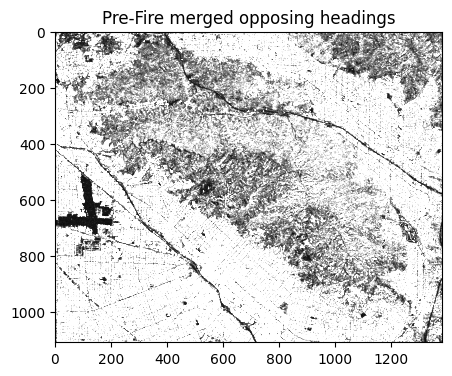

In [33]:
fig, axs = plt.subplots(figsize=(5,5))
plt.imshow(merged_arr_prefire, vmin=0, vmax=0.1, cmap="Greys_r")
plt.title('Pre-Fire merged opposing headings')

Text(0.5, 1.0, 'Post-Fire merged opposing headings')

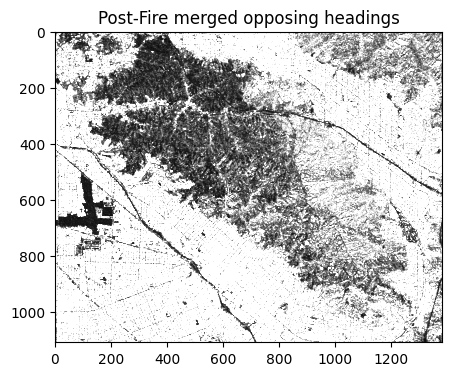

In [34]:
fig, axs = plt.subplots(figsize=(5,5))
plt.imshow(merged_arr_postfire, vmin=0, vmax=0.1, cmap="Greys_r")
plt.title('Post-Fire merged opposing headings')

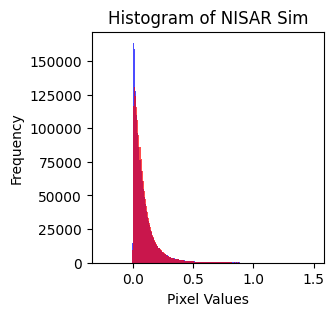

In [35]:
plt.figure(figsize=(3, 3))
plt.hist(merged_arr_postfire.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='blue')
plt.hist(merged_arr_prefire.flatten(), range = [-0.25, 1.5], bins=200, alpha=0.7, color='red')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of NISAR Sim')
plt.show()

# Lee Filter

The NISAR simulated data has more speckle - use the modified lee filter for decrease data noise.

In [36]:
lee_merged_arr_prefire = enhanced_lee(merged_arr_prefire, 7, 1)
lee_merged_arr_postfire = enhanced_lee(merged_arr_postfire, 7, 1)

# Data Visualization

With the data already loaded in, can do some visualization and look at a fire severity classification (and export).

<ipython-input-73-29caaa3c8d53>:3: RuntimeWarning: divide by zero encountered in divide
  HV_log = np.log(np.divide(lee_merged_arr_prefire, lee_merged_arr_postfire))
<ipython-input-73-29caaa3c8d53>:5: RuntimeWarning: divide by zero encountered in divide
  HV_ratio = np.divide(lee_merged_arr_prefire, lee_merged_arr_postfire)


Text(0.5, 1.0, 'HV Diff')

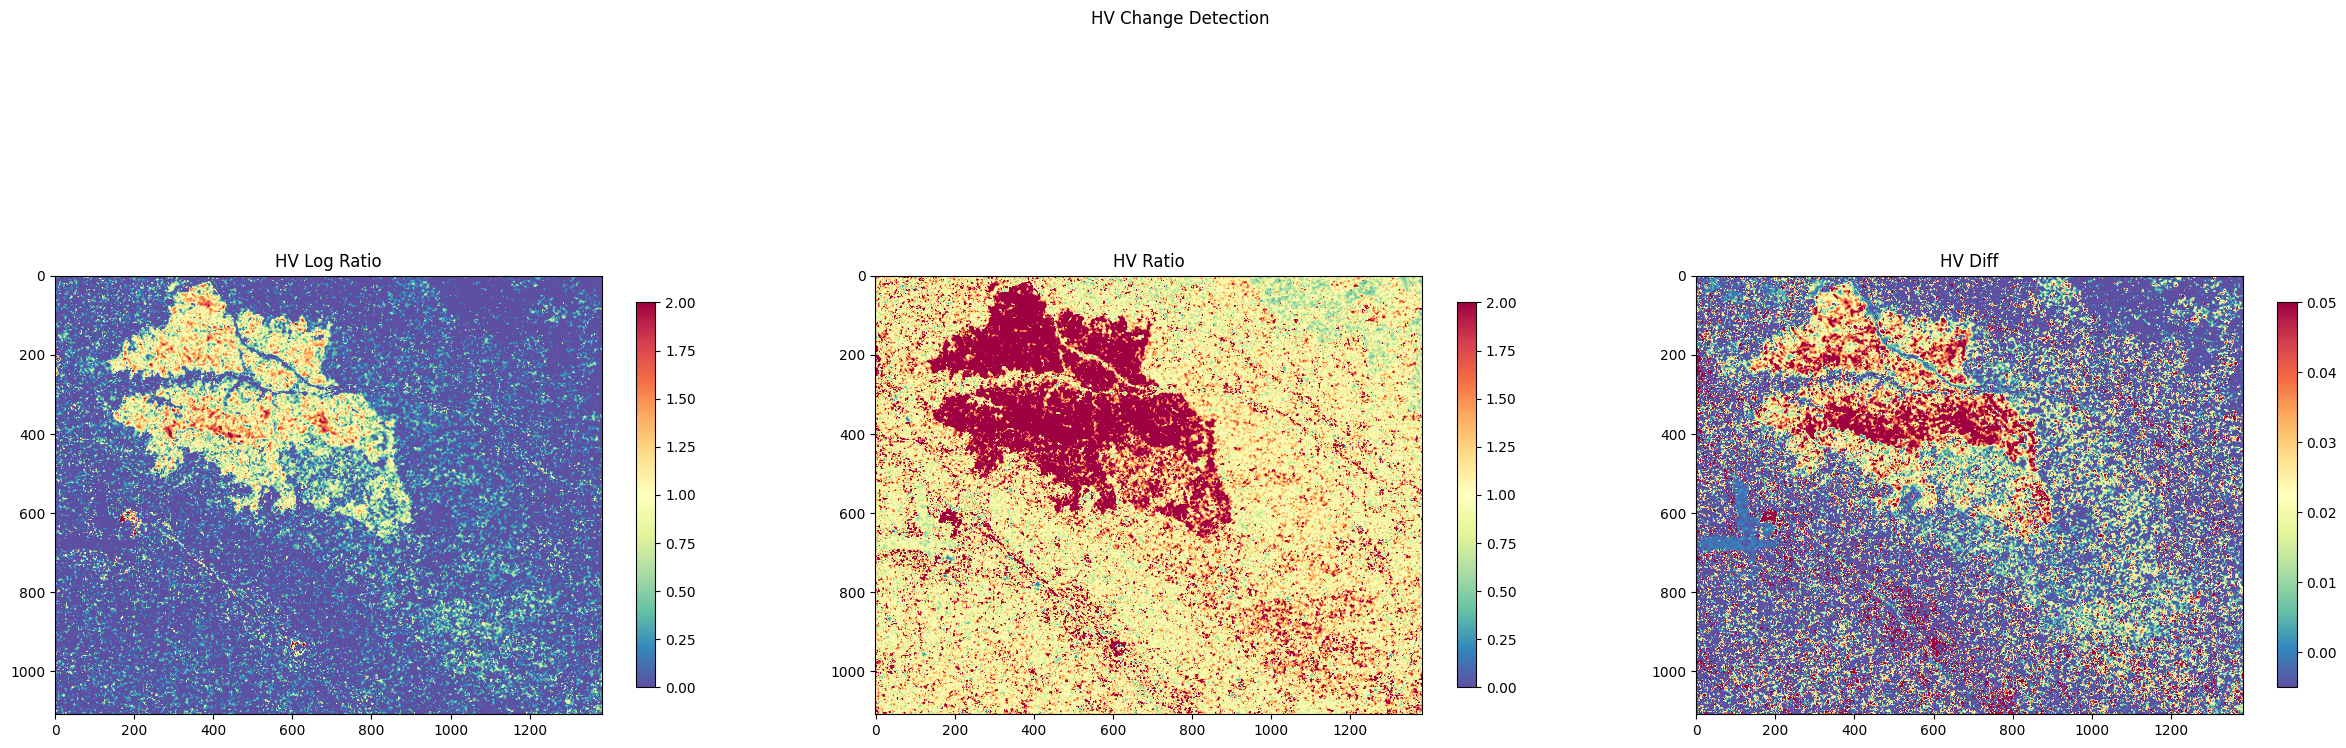

In [73]:
#@title Plot HV Change Detection
# Find the HV log ratio between 2014 and 2017 UAVSAR acquisitions
HV_log = np.log(np.divide(lee_merged_arr_prefire, lee_merged_arr_postfire))
# Find the HV ratio between 2014 and 2017 UAVSAR acquisitions
HV_ratio = np.divide(lee_merged_arr_prefire, lee_merged_arr_postfire)
# Find the HV difference
HV_diff = np.subtract(lee_merged_arr_prefire, lee_merged_arr_postfire)

fig, axs = plt.subplots(1,3,figsize=(30,10))
fig.suptitle('HV Change Detection')

HV_log_plot = axs[0].imshow(HV_log, vmin=0, vmax=2, cmap="Spectral_r")
fig.colorbar(HV_log_plot, ax=axs[0], shrink=0.5)
axs[0].set_title('HV Log Ratio')

HV_ratio_plot = axs[1].imshow(HV_ratio, vmin=0, vmax=2, cmap="Spectral_r")
fig.colorbar(HV_ratio_plot, ax=axs[1], shrink=0.5)
axs[1].set_title('HV Ratio')

HV_diff_plot = axs[2].imshow(HV_diff, vmin=-0.005, vmax=0.05, cmap="Spectral_r")
fig.colorbar(HV_diff_plot, ax=axs[2], shrink=0.5)
axs[2].set_title('HV Diff')

In [ ]:
## histogram
# plt.figure(figsize=(8, 6))
# plt.hist(HV_log.flatten(), bins=200, alpha=0.7, color='blue')
# plt.xlabel('Pixel Values')
# plt.ylabel('Frequency')
# plt.title('Histogram of NISAR Sim HV Log Ratio')
# plt.show()

Otsu Thresholding for Burned / Not Burned

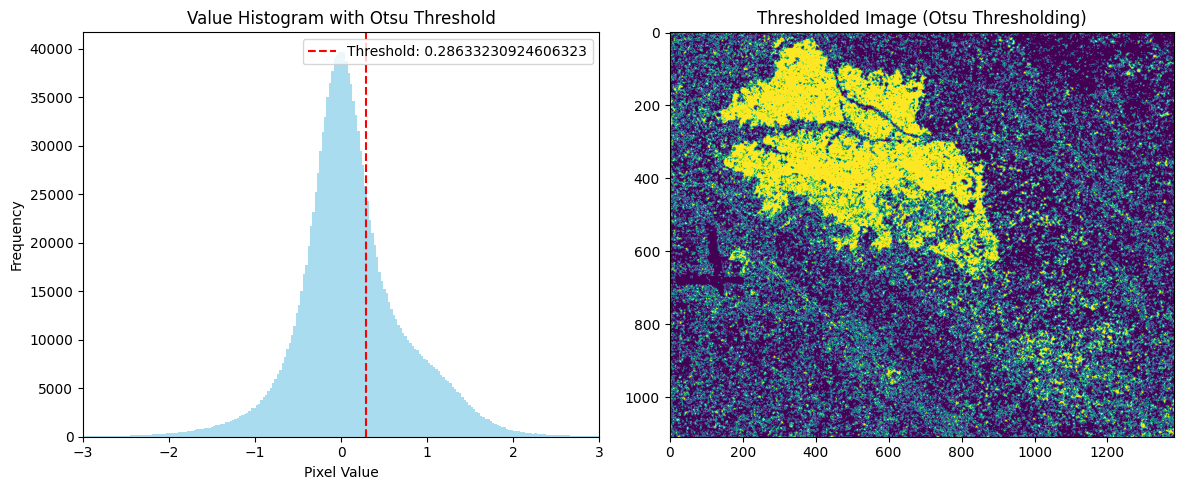

In [77]:
# Extract cleaned array excluding NaN and infinity values
out_image = HV_log.copy()
cleaned_array = out_image[~np.logical_or(np.isnan(out_image), np.isinf(out_image))]
# Perform Otsu's thresholding on the cleaned array
threshold_value = filters.threshold_otsu(cleaned_array)

HV_log = out_image.squeeze()
# Apply the threshold to the original array
thresholded_image = HV_log > threshold_value

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
axes[0].hist(cleaned_array.ravel(), bins=500, color='skyblue', alpha=0.7)
axes[0].axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold: {threshold_value}')
axes[0].set_title('Value Histogram with Otsu Threshold')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(-3, 3)  # Set x-axis limits
axes[0].legend()

# Plot the thresholded image
axes[1].imshow(thresholded_image)#, cmap='YlGn_r')
axes[1].set_title('Thresholded Image (Otsu Thresholding)')

plt.tight_layout()
plt.show()

In [59]:
## Have geojson of Verdugos extent but want to make a rasterized version to perform masking

def rasterize_geojson(input_geojson, output_raster, reference_geotiff):
    # Open reference GeoTIFF to get extent and resolution
    with rio.open(reference_geotiff) as src:
        transform = src.transform
        crs = src.crs
        width = src.width
        height = src.height
        dtype = np.uint8  # Assuming you want 8-bit output raster

        # Read GeoJSON file
        gdf = gpd.read_file(input_geojson)

        # Reproject GeoJSON to match CRS of reference GeoTIFF
        gdf = gdf.to_crs(src.crs)

        # Get mask for the GeoJSON features
        out_shape = (height, width)
        mask = geometry_mask(gdf['geometry'], transform=transform, invert=True, out_shape=out_shape)

    # Create output raster with the mask
    with rio.open(
            output_raster,
            'w',
            driver='GTiff',
            width=width,
            height=height,
            count=1,
            dtype=dtype,
            crs=crs,
            transform=transform
    ) as dst:
        dst.write(mask.astype(dtype), 1)


input_geojson = "verdugos.geojson"
output_raster = "verdugos.tif"
reference_geotiff = "SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02_clipped.tif"

rasterize_geojson(input_geojson, output_raster, reference_geotiff)

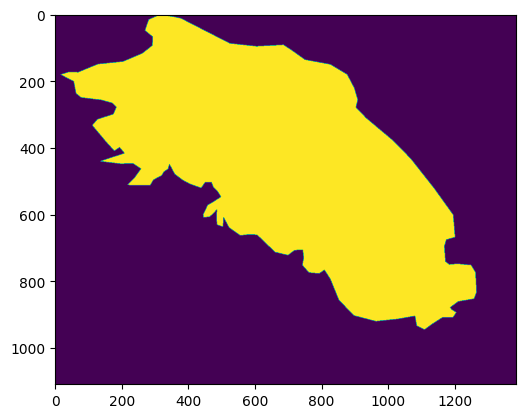

In [60]:
geotiff = rio.open('verdugos.tif').read(1)
plt.imshow(geotiff, vmin=0, vmax=1)

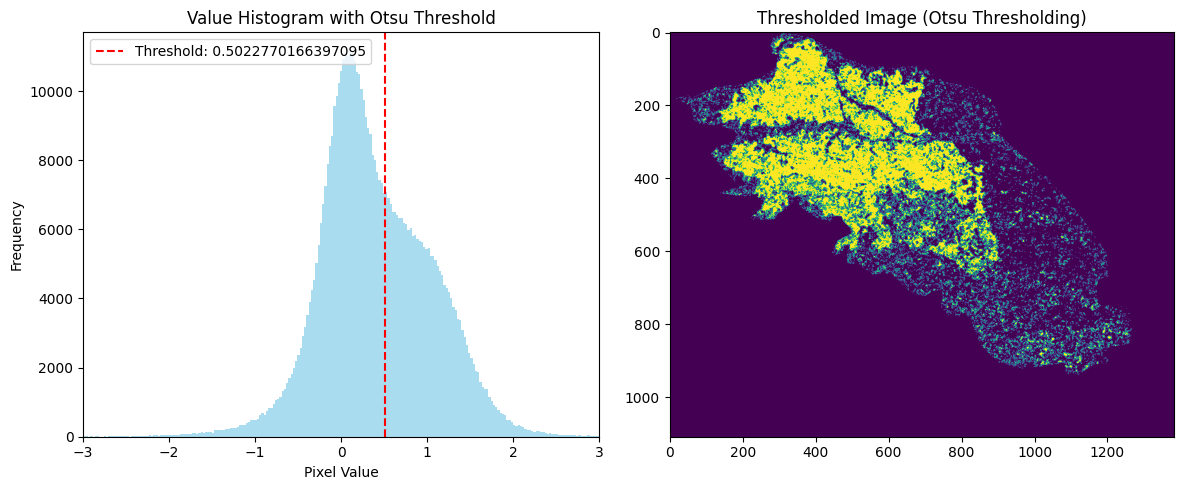

In [65]:
# Load GeoTIFF
with rio.open("verdugos.tif") as src:
    geotiff_array = src.read(1)  # Assuming it's a single band raster
    geotiff_array[geotiff_array != 1] = 0  # Set non-1 values to 0
    mask_transform = src.transform

# Extract cleaned array excluding NaN and infinity values
out_image_premask = HV_log.copy()

# Apply the mask
out_image = out_image_premask * geotiff_array
# cleaned_array = cleaned_array[cleaned_array != 0]
out_image[out_image == 0] = np.nan

cleaned_array = out_image[~np.logical_or(np.isnan(out_image), np.isinf(out_image))]

# Perform Otsu's thresholding on the masked array
threshold_value = filters.threshold_otsu(cleaned_array)

HV_log = out_image.squeeze()

# Apply the threshold to the original array
thresholded_image = HV_log > threshold_value

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram
axes[0].hist(cleaned_array.ravel(), bins=500, color='skyblue', alpha=0.7)
axes[0].axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold: {threshold_value}')
axes[0].set_title('Value Histogram with Otsu Threshold')
axes[0].set_xlabel('Pixel Value')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(-3, 3)  # Set x-axis limits
axes[0].legend()

# Plot the thresholded image
axes[1].imshow(thresholded_image)
axes[1].set_title('Thresholded Image (Otsu Thresholding)')

plt.tight_layout()
plt.show()


In [48]:
# ## Uncomment to use if not masking
# # Extract cleaned array excluding NaN and infinity values
# out_image = HV_log.copy()
# cleaned_array = out_image[~np.logical_or(np.isnan(out_image), np.isinf(out_image))]
# # Perform Otsu's thresholding on the cleaned array
# threshold_value = filters.threshold_otsu(cleaned_array)

# HV_log = out_image.squeeze()
# # Apply the threshold to the original array
# thresholded_image = HV_log > threshold_value

# # Plotting
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # Plot the histogram
# axes[0].hist(cleaned_array.ravel(), bins=500, color='skyblue', alpha=0.7)
# axes[0].axvline(x=threshold_value, color='red', linestyle='--', label=f'Threshold: {threshold_value}')
# axes[0].set_title('Value Histogram with Otsu Threshold')
# axes[0].set_xlabel('Pixel Value')
# axes[0].set_ylabel('Frequency')
# axes[0].set_xlim(-3, 3)  # Set x-axis limits
# axes[0].legend()

# # Plot the thresholded image
# axes[1].imshow(thresholded_image)#, cmap='YlGn_r')
# axes[1].set_title('Thresholded Image (Otsu Thresholding)')

# plt.tight_layout()
# plt.show()

Thresholding for High Severity

Options:

1. Otsu thresholding on just the burned distribution
2. Select a number of standard deviations
3. Find a percentile (i.e. 90th of burned)


** Want the thresholds/histograms to only include the Verdugo Mountains, but the classification output can be the whole subset area

In [66]:
percentile = 90
stddev_number = 2

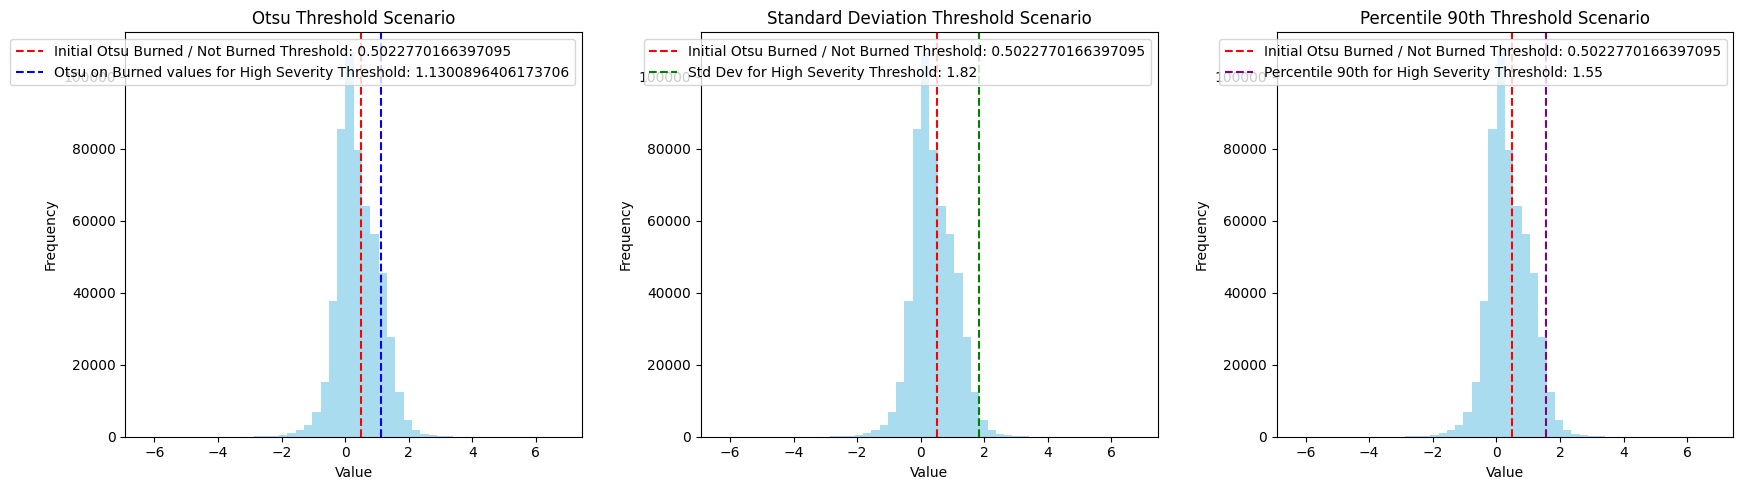

In [67]:
#@title Thresholding options

data = cleaned_array

# Find the initial threshold using Otsu's method
initial_threshold = filters.threshold_otsu(data)

# Mask out the lower distribution by setting values below the initial threshold to NaN
data_low_masked = np.where(data < initial_threshold, np.nan, data)

# Option 1: Apply Otsu's method to the higher distribution (masked)
higher_distribution = data_low_masked[~np.isnan(data_low_masked)]
higher_threshold = filters.threshold_otsu(higher_distribution)

# Option 2: Calculate high severity threshold based on standard deviations
high_severity_values = data[data > initial_threshold]
num_std_deviations = stddev_number  # set number of stddev
high_severity_threshold_std = np.nanmean(high_severity_values) + num_std_deviations * np.nanstd(high_severity_values)

# Option 3: Calculate high severity threshold as the 90th percentile above the initial threshold
percentile_90th = np.percentile(higher_distribution, percentile)
high_severity_threshold_percentile = percentile_90th

# Plotting
plt.figure(figsize=(18, 5))

# Plot for Otsu scenario
plt.subplot(1, 3, 1)
plt.hist(data.ravel(), bins=50, color='skyblue', alpha=0.7)
plt.axvline(x=initial_threshold, color='red', linestyle='--', label=f'Initial Otsu Burned / Not Burned Threshold: {initial_threshold}')
plt.axvline(x=higher_threshold, color='blue', linestyle='--', label=f'Otsu on Burned values for High Severity Threshold: {higher_threshold}')
plt.title('Otsu Threshold Scenario')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Plot for Standard Deviation scenario
plt.subplot(1, 3, 2)
plt.hist(data.ravel(), bins=50, color='skyblue', alpha=0.7)
plt.axvline(x=initial_threshold, color='red', linestyle='--', label=f'Initial Otsu Burned / Not Burned Threshold: {initial_threshold}')
plt.axvline(x=high_severity_threshold_std, color='green', linestyle='--', label=f'Std Dev for High Severity Threshold: {high_severity_threshold_std:.2f}')
plt.title('Standard Deviation Threshold Scenario')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Plot for Percentile 90th scenario
plt.subplot(1, 3, 3)
plt.hist(data.ravel(), bins=50, color='skyblue', alpha=0.7)
plt.axvline(x=initial_threshold, color='red', linestyle='--', label=f'Initial Otsu Burned / Not Burned Threshold: {initial_threshold}')
plt.axvline(x=high_severity_threshold_percentile, color='purple', linestyle='--', label=f'Percentile 90th for High Severity Threshold: {high_severity_threshold_percentile:.2f}')
plt.title('Percentile 90th Threshold Scenario')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

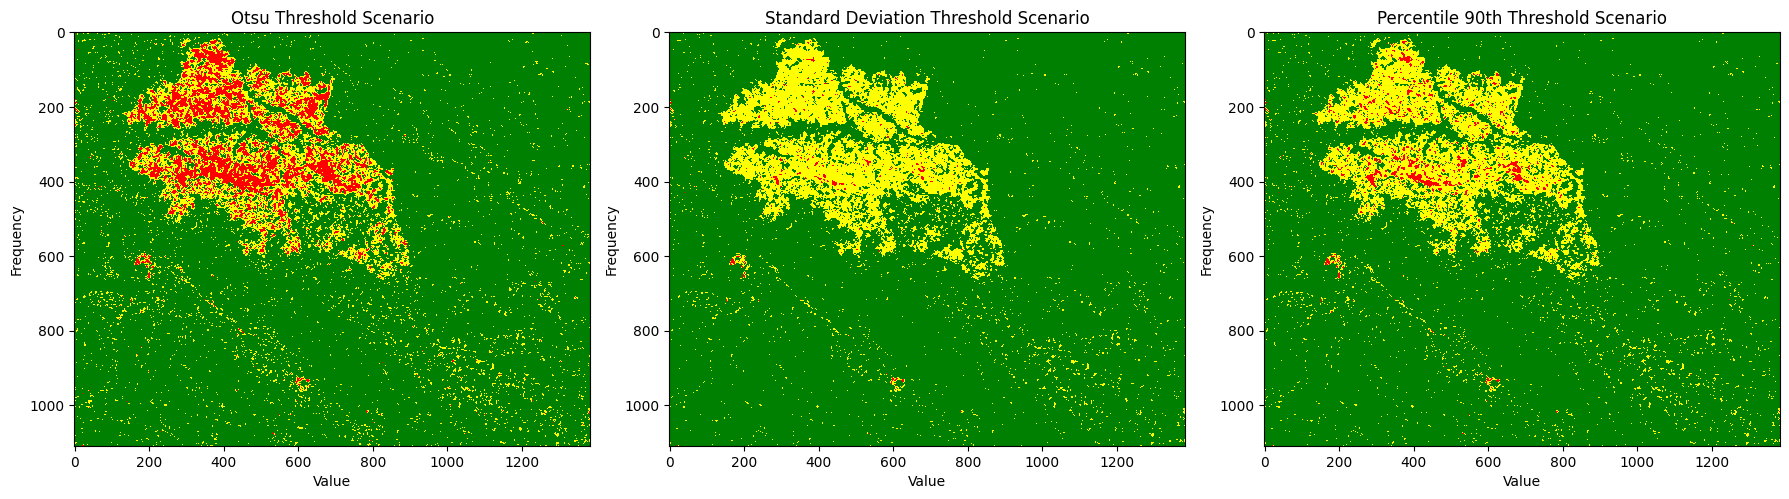

In [74]:
#@title Resulting fire severity classifications (from thresholding options)

# Define your threshold values for each scenario
burn_thresh_hv = threshold_value

# Copy the HV_log array
hv = HV_log.copy()

# Create a copy for classifying for each scenario
hv_class_otsu = HV_log.copy()
hv_class_std = HV_log.copy()
hv_class_percentile = HV_log.copy()

# Otsu Threshold Scenario
severity_thresh_hv = higher_threshold

hv_class_otsu[hv > severity_thresh_hv] = 30  # High Burn Severity UAVSAR
hv_class_otsu[(hv < severity_thresh_hv) & (hv >= burn_thresh_hv)] = 20  # Moderate Burn Severity UAVSAR
hv_class_otsu[hv < burn_thresh_hv] = 10  # Unburned UAVSAR
hv_class_otsu[hv_class_otsu < 10] = np.nan  # Set remaining scenarios to be ignored

# Standard Deviation Threshold Scenario
severity_thresh_hv = high_severity_threshold_std

hv_class_std[hv > severity_thresh_hv] = 30  # High Burn Severity UAVSAR
hv_class_std[(hv < severity_thresh_hv) & (hv >= burn_thresh_hv)] = 20  # Moderate Burn Severity UAVSAR
hv_class_std[hv < burn_thresh_hv] = 10  # Unburned UAVSAR
hv_class_std[hv_class_std < 10] = np.nan  # Set remaining scenarios to be ignored

# Percentile 90th Threshold Scenario
severity_thresh_hv = high_severity_threshold_percentile

hv_class_percentile[hv > severity_thresh_hv] = 30  # High Burn Severity UAVSAR
hv_class_percentile[(hv < severity_thresh_hv) & (hv >= burn_thresh_hv)] = 20  # Moderate Burn Severity UAVSAR
hv_class_percentile[hv < burn_thresh_hv] = 10  # Unburned UAVSAR
hv_class_percentile[hv_class_percentile < 10] = np.nan  # Set remaining scenarios to be ignored


cmap = ListedColormap(["green", "yellow", "red"])

# Create the plots for each scenario
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Otsu Threshold Scenario
axes[0].imshow(hv_class_otsu, cmap=cmap)
axes[0].set_title('Otsu Threshold Scenario')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

# Plot for Standard Deviation Threshold Scenario
axes[1].imshow(hv_class_std, cmap=cmap)
axes[1].set_title('Standard Deviation Threshold Scenario')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

# Plot for Percentile 90th Threshold Scenario
axes[2].imshow(hv_class_percentile, cmap=cmap)
axes[2].set_title('Percentile 90th Threshold Scenario')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [75]:
# choose the threshold
high_severity_threshold_value = 1.55

## Fire Severity Classification (to export)

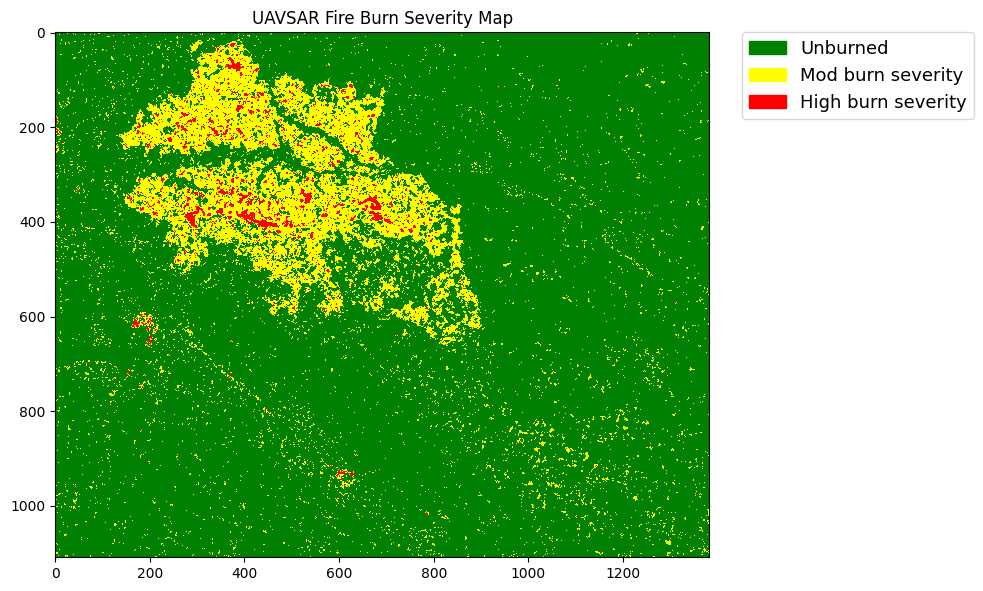

In [76]:
# Separate into 4 classes depending on threshold
burn_thresh_hv = threshold_value
severity_thresh_hv = high_severity_threshold_value
hv = HV_log.copy()
hv_class = HV_log.copy()

#High Burn Severity UAVSAR (above high severity threshold)
hv_class[hv > severity_thresh_hv] = 30

# Moderate Burn Severity UAVSAR (above burned threshold and below high severity threshold)
hv_class[(hv < severity_thresh_hv) & (hv >= burn_thresh_hv)] = 20

# Unburned UAVSAR (below burned threshold)
hv_class[hv < burn_thresh_hv] = 10

# Remaining scenarios ignored
hv_class[hv_class < 10] = np.nan

# Define the colors you want
cmap = ListedColormap(["green", "yellow", "red"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)
f, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(hv_class, cmap = cmap)

ep.draw_legend(im, titles=["Unburned", "Mod burn severity", "High burn severity"], classes=[10, 20, 30])

# Add general map title
plt.title("UAVSAR Fire Burn Severity Map")
plt.tight_layout()

Post-Classification Filtering

- Takes a few minutes to run

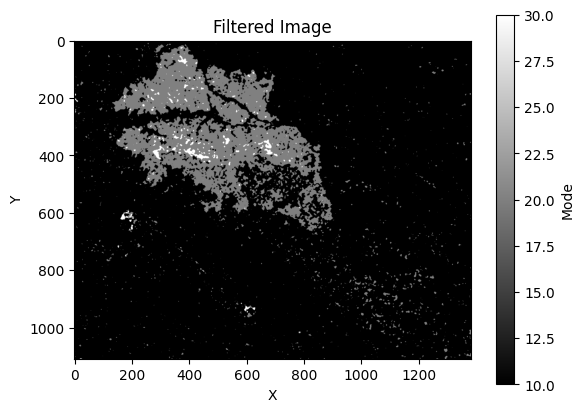

In [78]:
from scipy.ndimage import generic_filter
from scipy.stats import mode

# Assuming `hv_class_otsu` is defined

def filter_function(invalues):
    invalues_mode = mode(invalues, axis=None, nan_policy='omit')
    return invalues_mode[0]

# Applying the filter function using generic_filter
filtered_image = generic_filter(hv_class, function=filter_function, size=5)

# Plot the filtered image
plt.imshow(filtered_image, cmap='gray')
plt.title('Filtered Image')
plt.colorbar(label='Mode')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Export
- HV_log
- fire severity product
- send to UAVSAR staging area
- can replace filename & variable if want to export other layers individually

In [72]:
# Open the reference raster
reference_raster = 'SanAnd_08525_14158_003_141023_L090HVHV_CG_138A_02_masked.tif'
with rio.open(reference_raster) as src:
    # Get metadata from the reference raster
    meta = src.meta

    # Update metadata to match the NumPy array
    meta.update({
        'dtype': HV_log.dtype,
        'count': 1  # Assuming there's only one band
    })

    # Save HV Log Ratio
    with rio.open("HV_log_nisarsim.tif", 'w', **meta) as dst:
        dst.write(HV_log, 1)  # Assuming there's only one band (band index 1)

    # Save HV Log Ratio Classification
    with rio.open("HV_log_nisarsim_classification.tif", 'w', **meta) as dst:
        dst.write(hv_class, 1)  # Assuming there's only one band (band index 1)

or export a data stack

1. HV Pre-Fire (Merged opposite headings and Lee Filtered)
2. HV Post-Fire (Merged opposite headings and Lee Filtered)
3. HV Log
4. Fire Severity Classification

In [83]:
# Open the reference raster
with rio.open(reference_raster) as src:
    # Get metadata from the reference raster
    meta = src.meta

    # Update metadata to handle multiple bands
    meta.update({
        'dtype': 'float32',  # Assuming all bands are of float32 dtype
        'count': 5,          # Number of bands
        'driver': 'GTiff'
    })

    # Add band descriptions to the metadata
    meta['descriptions'] = ('HV Pre-Fire', 'HV Post-Fire','HV Log Ratio', 'HV Log Ratio Classification')

    # Create a new stack with multiple bands
    with rio.open("nisarsim_stack.tif", 'w', **meta) as dst:
        dst.write(merged_arr_prefire, 1)
        dst.write(merged_arr_postfire, 2)
        dst.write(HV_log, 3)
        dst.write(hv_class, 4) #note somewhere the thresholds used
        dst.write(geotiff, 5) #rasterized verdugos mask
